# Practical Work

<b> Student: </b> Jonas Fallmann <br>
<b> Matrikulation number </b> 12018700 <br>
<b> Topic:</b> Evaulating gender bias of explained recommender systems<br>
<b> Institute: </b> Institute of Computational Perception, Johannes Kepler University Linz

## Outline
Recent advances in the field of recommender systems focus in a big part on explanations of recommended Items. Explainability has been shown to aid user trust and results in higher conversion rates in the online shopping domain. As an example, explanations in the music domain could be of the following form:

<b>Recommended Item:</b> Clocks and Whoopty by Pintel Ragetti<br>
<b> Explanation: </b>  



# Train Model

### Load config and create Dataset

In [1]:
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.knowledge_aware_recommender import KGAT
from recbole.trainer import KGATTrainer
from recbole.utils import init_seed, init_logger

train_model = False
create_paths = False

In [2]:

# configurations initialization
config = Config(model='KGAT', dataset='rb_lfm', config_file_list=['lfm.yaml'])

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()

# write config info into log
logger.info(config)

# dataset creating and filtering
dataset = create_dataset(config)
logger.info(dataset)

# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)


20 Mar 10:17    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = ./data/rb_lfm
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 40
train_batch_size = 1024
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [8, 1, 1]}, 'group_by': 'user', 'order': 'TO', 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 1024
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separator =  
USER_ID_FIELD =

### Train model and evaluate

In [3]:
if train_model:
    # model loading and initialization
    model = KGAT(config, train_data._dataset).to(config['device'])
    logger.info(model)

    # trainer loading and initialization
    trainer = KGATTrainer(config, model)

    print('Starting to fit model')
    # model training
    best_valid_score, best_valid_result = trainer.fit(train_data, valid_data, saved=True, show_progress=True)

    print('Evaluating model')
    # model evaluation
    test_result = trainer.evaluate(test_data, load_best_model=True)
    print(test_result)

# Load best model

In [4]:
import os
import torch

In [5]:
latest_model = 'saved/%s' % os.listdir('saved')[-2]

In [6]:
latest_model

'saved/model_TO.pth'

In [7]:
state_dict = torch.load(latest_model, map_location='cuda')
model = KGAT(config, train_data._dataset).to(config['device'])

model.load_state_dict(state_dict['state_dict'])

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/dgl/subgraph.py:288: DGLWarning: Key word argument preserve_nodes is deprecated. Use relabel_nodes instead.
  dgl_warning(
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:159: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  indices = torch.LongTensor([final_adj_matrix.row, final_adj_matrix.col])


<All keys matched successfully>

In [8]:
trainer = KGATTrainer(config, model)
test_result = trainer.evaluate(test_data, load_best_model=False)
print(test_result)

OrderedDict([('ndcg@10', 0.0221), ('hit@10', 0.1449), ('precision@10', 0.0198)])


In [142]:
from recbole.utils import (
    ensure_dir,
    get_local_time,
    early_stopping,
    calculate_valid_score,
    dict2str,
    EvaluatorType,
    KGDataLoaderState,
    get_tensorboard,
    set_color,
    get_gpu_usage,
    WandbLogger,
)
from recbole.evaluator import Evaluator, Collector
from recbole.data.dataloader import FullSortEvalDataLoader

eval_collector = Collector(config)
evaluator = Evaluator(config)
wandblogger = WandbLogger(config)

def _map_reduce(result, num_sample):
        gather_result = {}
        total_sample = [
            torch.zeros(1).to(config['device']) for _ in range(config["world_size"])
        ]
        torch.distributed.all_gather(
            total_sample, torch.Tensor([num_sample]).to(config['device'])
        )
        total_sample = torch.cat(total_sample, 0)
        total_sample = torch.sum(total_sample).item()
        for key, value in result.items():
            result[key] = torch.Tensor([value * num_sample]).to(config['device'])
            gather_result[key] = [
                torch.zeros_like(result[key]).to(config['device'])
                for _ in range(config["world_size"])
            ]
            torch.distributed.all_gather(gather_result[key], result[key])
            gather_result[key] = torch.cat(gather_result[key], dim=0)
            gather_result[key] = round(
                torch.sum(gather_result[key]).item() / total_sample,
                config["metric_decimal_place"],
            )
        return gather_result

def _full_sort_batch_eval(batched_data, item_num):
    interaction, history_index, positive_u, positive_i = batched_data
    scores = model.full_sort_predict(interaction.to(config['device']))
    scores = scores.view(-1, item_num)
    scores[:, 0] = -np.inf
    if history_index is not None:
        scores[history_index] = -np.inf
    return interaction, scores, positive_u, positive_i
    
@torch.no_grad()
def evaluate(eval_data, filterList, show_progress=False):
    if not eval_data:
        return
    model.eval()
    item_tensor = None
    if isinstance(eval_data, FullSortEvalDataLoader):
        eval_func = _full_sort_batch_eval
        if item_tensor is None:
            item_tensor = eval_data._dataset.get_item_feature().to(config['device'])
    if config["eval_type"] == EvaluatorType.RANKING:
        tot_item_num = eval_data._dataset.item_num

    iter_data = (
        tqdm(
            eval_data,
            total=len(eval_data),
            ncols=100,
            desc=set_color(f"Evaluate   ", "pink"),
        )
        if show_progress
        else eval_data
    )

    num_sample = 0
    gpu_available = torch.cuda.is_available() and config["use_gpu"]
    for batch_idx, batched_data in enumerate(iter_data):
        interaction, scores, positive_u, positive_i = eval_func(batched_data, eval_data._dataset.item_num)
        user_id = interaction['user_id'].cpu().numpy().item()
        if user_id not in filterList:
            continue
        num_sample += len(batched_data)
                                     
        if gpu_available and show_progress:
            iter_data.set_postfix_str(
                set_color("GPU RAM: " + get_gpu_usage(config['device']), "yellow")
            )
        eval_collector.eval_batch_collect(
            scores, interaction, positive_u, positive_i
        )
    eval_collector.model_collect(model)
    struct = eval_collector.get_data_struct()
    result = evaluator.evaluate(struct)
    if not config["single_spec"]:
        result = _map_reduce(result, num_sample)
    wandblogger.log_eval_metrics(result, head="eval")
    return result

In [143]:
evaluate(test_data, male_internal_user_ids)

OrderedDict([('ndcg@10', 0.0219), ('hit@10', 0.1453), ('precision@10', 0.02)])

In [144]:
evaluate(test_data, female_internal_user_ids)

OrderedDict([('ndcg@10', 0.0228), ('hit@10', 0.1431), ('precision@10', 0.019)])

# Prepare for model evaluation

## Create graph from attention matrix

In [9]:
import os
import torch
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from recbole.data.interaction import Interaction


In [10]:
def get_path(Pr, j):
    path = [j]
    k = j
    while Pr[k] != -9999:
        path.append(Pr[k])
        k = Pr[k]
    return path[::-1]

In [11]:
from enum import Enum
class DistanceMode(Enum):
    Inverse=1
    RBF=2
    Linear=3

In [12]:
attention_matrix = model.A_in.cpu().coalesce()
attention_matrix_size = attention_matrix.size()[0] # since it is square

In [13]:
def create_scipy_matrix(distance_mode: str, size: int):
    attention_values = attention_matrix.values().numpy()
    if distance_mode == DistanceMode.Inverse:
        attention_values = 1/attention_values
    if distance_mode == DistanceMode.RBF:
        attention_values = np.exp(-attention_values**2)
    if distance_mode == DistanceMode.Linear:
        attention_values = 1-attention_values
    return coo_matrix((attention_values, (attention_matrix.indices()[0].numpy(), attention_matrix.indices()[1].numpy())), shape=(size,size))

In [14]:
graph_matrix = create_scipy_matrix(DistanceMode.RBF, attention_matrix_size)

## Create shortest path for k top predictions

<b> Important note:</b> Id's in the attention matrix are shiftet by the number of users `dataset.user_num`. So fetching an id using the token i.e. token2id results in an id not yet shifted. So to get the corresponding attention-matrix-id we need to shift items and entities!

In [15]:
user_paths = {}
if create_paths:
    for batch_idx, batched_data in enumerate(tqdm(test_data)):
        interaction, history_index, positive_u, positive_i = batched_data
        user_id = interaction['user_id'].cpu().numpy().item()

        predictions = model.full_sort_predict(interaction).detach().cpu().numpy()
        recommended_items = np.argsort(predictions)
        recommended_items = recommended_items[np.isin(recommended_items, positive_i + dataset.user_num)]

        # now calculate shortest distances for current user
        shortest_distances, predecessors = shortest_path(graph_matrix, directed=True,  return_predecessors = True, indices=[user_id])

        # calculate the paths for the top k recommended items
        paths = []
        for item_idx in recommended_items:
            path = get_path(predecessors[0], item_idx)
            paths.append(np.asarray(path, dtype=int))
        user_paths[user_id] = paths

In [16]:
import pickle
file_name = 'paths.pkl'
if create_paths:
    with open(file_name, 'wb') as file:
        pickle.dump(user_paths, file)
        print(f'Object successfully saved to "{file_name}"')
else:
    with open(file_name, 'rb') as file:
        user_paths = pickle.load(file)
        print(f'Object successfully loaded from "{file_name}"')

Object successfully loaded from "paths.pkl"


In [17]:
gender_ids = dataset.token2id('entity_id', ['m', 'f'])

In [18]:
male_attention_row = np.asarray(graph_matrix.getrow(dataset.user_num + gender_ids[0]).todense())
male_attention_row

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
np.nonzero(male_attention_row)

(array([], dtype=int64), array([], dtype=int64))

In [20]:
male_attention_col = np.asarray(graph_matrix.getcol(dataset.user_num + gender_ids[0]).todense())
male_attention_col

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [21]:
np.nonzero(male_attention_col)

(array([168349, 168350, 168351, ..., 178066, 178068, 178069]),
 array([0, 0, 0, ..., 0, 0, 0]))

(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.92367e+05, 0.00000e+00, 0.00000e+00, 6.71000e+02]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

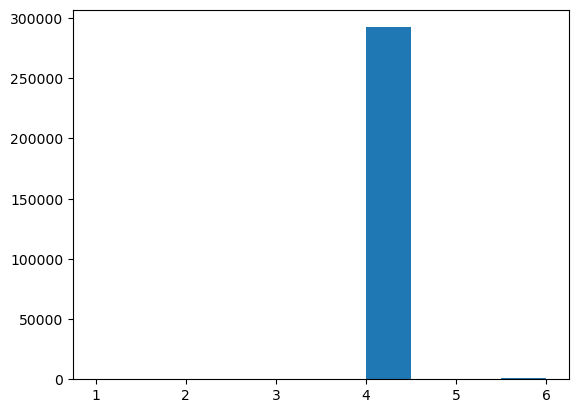

In [22]:
flat_list = [item for sublist in list(user_paths.values()) for item in sublist]
flat_lengths = [len(item) for item in flat_list]
plt.hist(flat_lengths)

# Evaluation

In [70]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticksplt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

## Load all users and divide into male and female

In [71]:
user_df = pd.read_csv('data/lfm/75percent_subset_users.tsv', sep='\t')

In [72]:
user_ids = list(user_paths.keys())

In [73]:
external_user_ids = [int(item) for item in dataset.id2token(dataset.uid_field, user_ids)]

In [74]:
# remove users that recbole removed in the dataset creation process
user_df = user_df[user_df.user_id.isin(external_user_ids)]

In [75]:
male_users = user_df[user_df.gender == 'm']
female_users = user_df[user_df.gender =='f']

In [76]:
print('Male users: %s, %s(%%)' % (len(male_users), len(male_users)/(len(male_users)+len(female_users))))
print('Male users: %s, %s(%%)' % (len(female_users), len(female_users)/(len(male_users)+len(female_users))))

Male users: 7857, 0.8115897118066315(%)
Male users: 1824, 0.18841028819336844(%)


<AxesSubplot: >

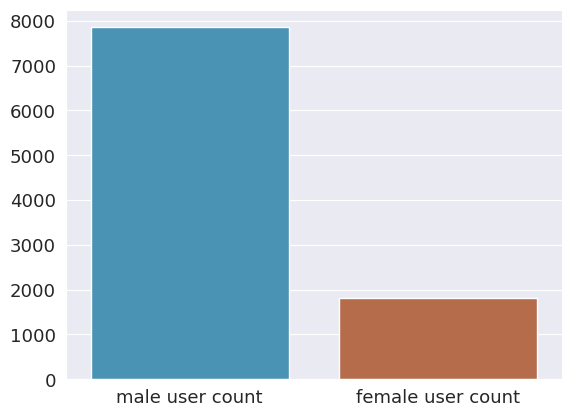

In [127]:
colors =['#3899C7', '#C76638']# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
sns.barplot(x=['male user count', 'female user count'], y=[len(male_users), len(female_users)], palette=customPalette)

In [78]:
male_internal_user_ids = dataset.token2id(dataset.uid_field, [str(item) for item in male_users.user_id.to_numpy()])
female_internal_user_ids = dataset.token2id(dataset.uid_field, [str(item) for item in female_users.user_id.to_numpy()])

In [79]:
def internal_id_to_gender(idx: int):
    return 'm' if idx in male_internal_user_ids else 'f'

In [80]:
def is_male(idx:int):
    return idx in male_internal_user_ids

### Calculate average path length on per user basis

In [81]:
user_average_path_lengths = {}
for key in user_paths.keys():
    paths_for_user = user_paths[key]
    average_path_length = np.mean([len(path) for path in paths_for_user])
    user_average_path_lengths[key] = average_path_length

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [82]:
length_distribution_dataframe = pd.DataFrame({'gender': [internal_id_to_gender(idx) for idx in user_paths.keys()], 'average path length': list(user_average_path_lengths.values()), 'male/female': ['_' for _ in user_paths.keys()]})
length_distribution_dataframe

,gender,average path length,male/female
0,m,4.0,_
1,f,4.0,_
2,m,4.0,_
3,m,4.0,_
4,m,4.0,_
...,...,...,...
9676,f,6.0,_
9677,f,4.0,_
9678,m,4.0,_
9679,m,4.0,_


Text(0.5, 0, 'Path length')

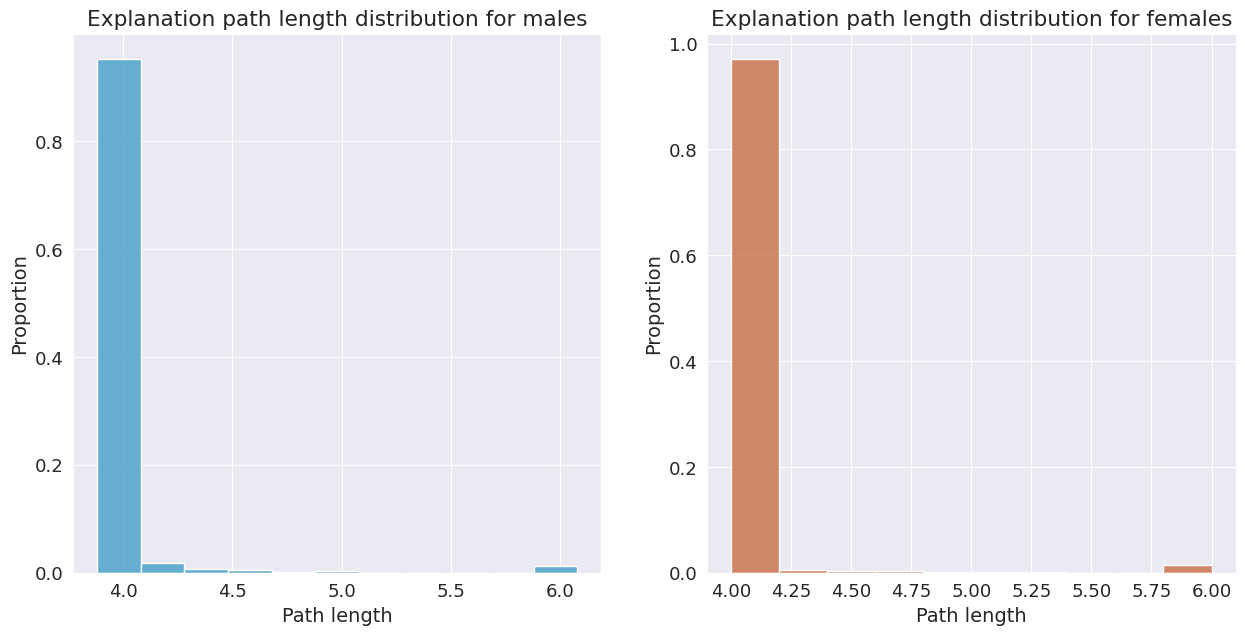

In [128]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

sns.histplot(data=length_distribution_dataframe[length_distribution_dataframe.gender == 'm'], ax=ax1, stat="proportion",
             x="average path length", kde=False,
             color="#3899C7",
             element="bars", legend=True, binwidth=.2)
ax1.set_title("Explanation path length distribution for males")
ax1.set_xlabel("Path length")

sns.histplot(data=length_distribution_dataframe[length_distribution_dataframe.gender == 'f'], ax=ax2, stat="proportion",
             x="average path length", kde=False,
             color='#C76638',
             element="bars", legend=True, binwidth=.2)
ax2.set_title("Explanation path length distribution for females")
ax2.set_xlabel("Path length")

<AxesSubplot: xlabel='male/female', ylabel='average path length'>

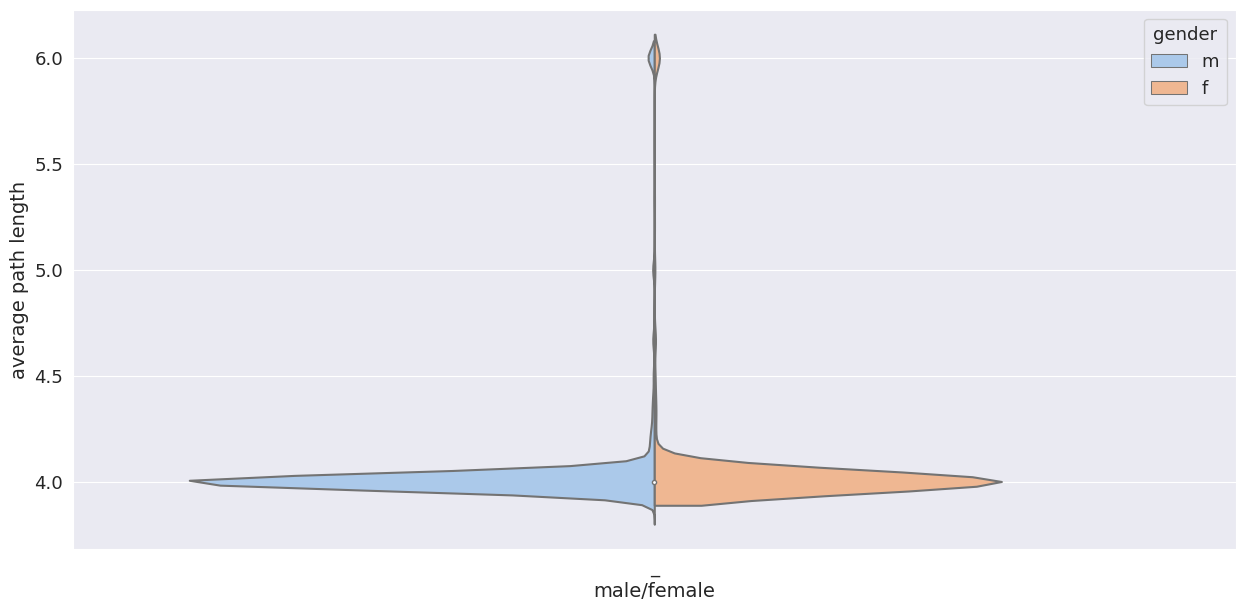

In [84]:
f = plt.figure(figsize=(15,7))
sns.violinplot(data=length_distribution_dataframe, y='average path length', x='male/female', hue='gender', split=True, palette="pastel", stat='proportion', legend=True)

<AxesSubplot: xlabel='male/female', ylabel='average path length'>

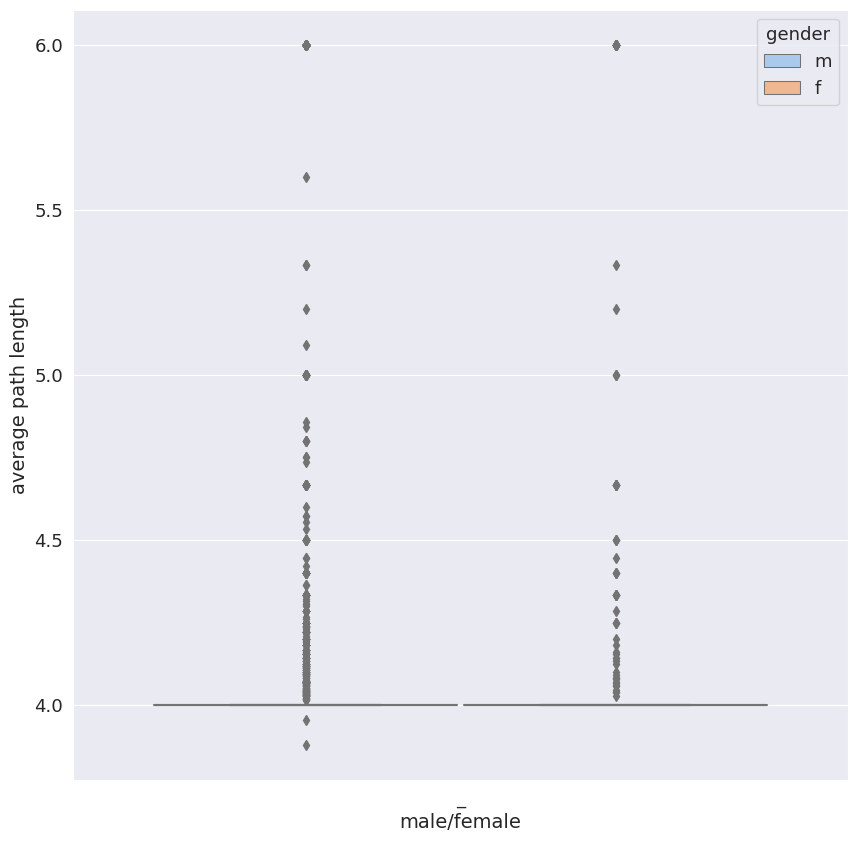

In [85]:
f = plt.figure(figsize=(10,10))
sns.boxplot(y="average path length", x="male/female",
            hue="gender", palette="pastel",
            data=length_distribution_dataframe)

## Evaluate path length per gender per user

In [86]:
import math

In [87]:
male_path_lengths = {}
for key in user_paths.keys():
    if key in male_internal_user_ids:
        if not math.isnan(user_average_path_lengths[key]):
            male_path_lengths[key] = user_average_path_lengths[key]

female_path_lengths = {}
for key in user_paths.keys():
    if key in female_internal_user_ids:
        if not math.isnan(user_average_path_lengths[key]):
            female_path_lengths[key] = user_average_path_lengths[key]

In [88]:
np.mean(list(male_path_lengths.values()))

4.039829725580958

In [89]:
np.median(list(male_path_lengths.values()))

4.0

In [90]:
np.mean(list(female_path_lengths.values()))

4.038229364326773

In [91]:
np.median(list(female_path_lengths.values()))

4.0

## Evaluate path length per gender

In [92]:
male_paths = {}
for key in user_paths.keys():
    if key in male_internal_user_ids:
        male_paths[key] = user_paths[key]

female_paths = {}
for key in user_paths.keys():
    if key in female_internal_user_ids:
        female_paths[key] = user_paths[key]

In [93]:
def average_path_length(paths: dict):
    flat_list = [item for sublist in list(paths.values()) for item in sublist]
    lengths = [len(item) for item in flat_list]
    return np.mean(lengths), lengths

In [94]:
male_average, male_lengths = average_path_length(male_paths)

In [95]:
female_average, female_lengths = average_path_length(female_paths)

In [96]:
female_average, male_average

(4.003492458472486, 4.00475676200415)

## Evaluate shared entities

In [97]:
male_shared_entities = []
female_shared_entities = []
for user_id in user_paths.keys():
    paths_for_user = user_paths[user_id]
    paths_without_start_and_end = [path[1:] for path in paths_for_user]
    paths_without_start_and_end = list(filter(lambda x: len(x) > 0, paths_without_start_and_end))

    try:
        concatenated_paths = np.concatenate(paths_without_start_and_end)
    except:
        pass
    
    if is_male(user_id):
        male_shared_entities.append(concatenated_paths)
    else:
        female_shared_entities.append(concatenated_paths)
    
male_shared_entities_concatenated = np.concatenate(male_shared_entities)
female_shared_entities_concatenated = np.concatenate(female_shared_entities)

In [98]:
def evaluate_gender_of_shared_entities(data):
    gender_token, counts = np.unique(data, return_counts=True)
    distribution = {gender_token[0]: counts[0]/np.sum(counts)}
    if len(gender_token) == 2:
        distribution[gender_token[1]] = counts[1]/np.sum(counts)
    return (distribution, len(data))

### Evaluate grouped by user by gender

In [99]:
male_shared_gender_statistics = []
for shared_entities in male_shared_entities:
    shared_users = shared_entities[shared_entities < dataset.user_num]
    shared_gender_tokens = [internal_id_to_gender(idx) for idx in shared_users]
    male_shared_gender_statistics.append(evaluate_gender_of_shared_entities(shared_gender_tokens))
    
female_shared_gender_statistics = []
for shared_entities in female_shared_entities:
    shared_users = shared_entities[shared_entities < dataset.user_num]
    shared_gender_tokens = [internal_id_to_gender(idx) for idx in shared_users]
    female_shared_gender_statistics.append(evaluate_gender_of_shared_entities(shared_gender_tokens))

In [100]:
male_shared_gender_df = pd.DataFrame({'gender': ['m' for _ in male_shared_gender_statistics], 'male_proportion': [float(item['m']) if 'm' in item else 0 for item, _ in male_shared_gender_statistics],'female_proportion': [float(item['f']) if 'f' in item else 0 for item,_ in male_shared_gender_statistics], 'male - female': ['_' for item in male_shared_gender_statistics] })
female_shared_gender_df = pd.DataFrame({'gender': ['f' for _ in female_shared_gender_statistics], 'male_proportion': [float(item['m']) if 'm' in item else 0 for item, _ in female_shared_gender_statistics],'female_proportion': [float(item['f']) if 'f' in item else 0 for item,_ in female_shared_gender_statistics], 'male - female': ['_' for item in female_shared_gender_statistics] })

In [101]:
male_shared_gender_df.mean()

/tmp/ipykernel_24008/325008653.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  male_shared_gender_df.mean()


male_proportion      0.866127
female_proportion    0.133873
dtype: float64

In [102]:
female_shared_gender_df.mean()

/tmp/ipykernel_24008/384587550.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  female_shared_gender_df.mean()


male_proportion      0.780622
female_proportion    0.219378
dtype: float64

(0.0, 0.3)

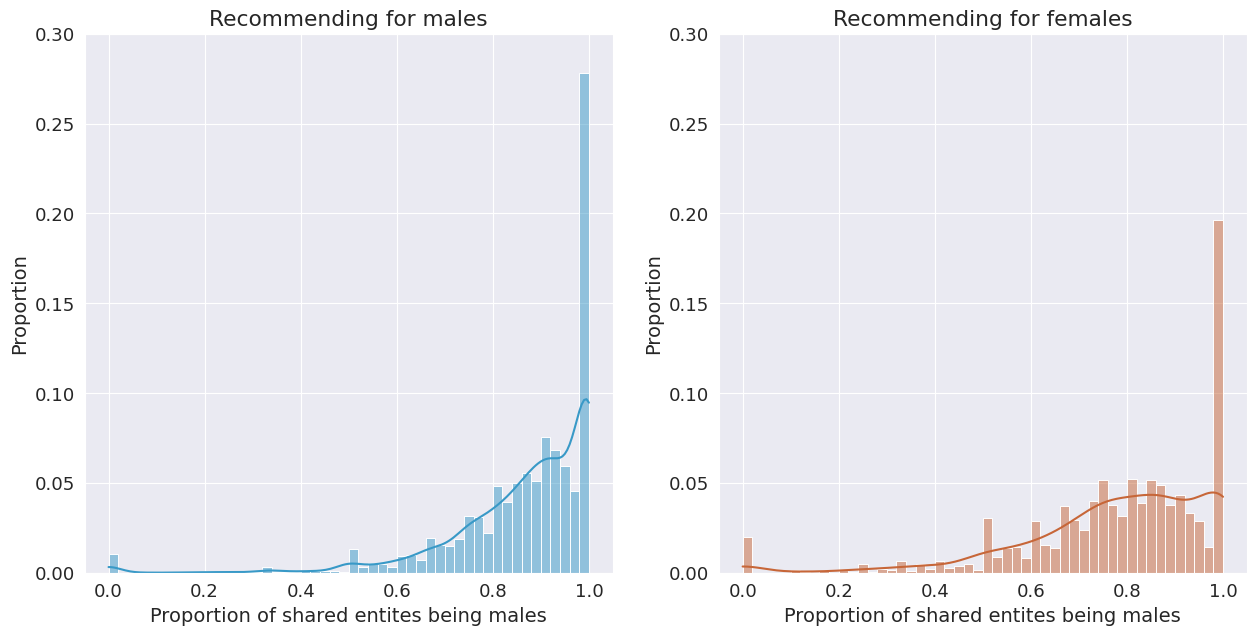

In [185]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

sns.histplot(data=male_shared_gender_df, ax=ax1, stat="proportion",
             x="male_proportion", kde=True,
             color="#3899C7",
             element="bars", legend=True, binwidth=.02)
ax1.set_title("Recommending for males")
ax1.set_xlabel("Proportion of shared entites being males")
ax1.set_ylim(0,0.30)

sns.histplot(data=female_shared_gender_df, ax=ax2, stat="proportion", multiple="stack",
             x="male_proportion", kde=True,
             color='#C76638',
             element="bars", legend=True, binwidth=.02)
ax2.set_title("Recommending for females")
ax2.set_xlabel("Proportion of shared entites being males")
ax2.set_ylim(0,0.30)


(0.0, 0.3)

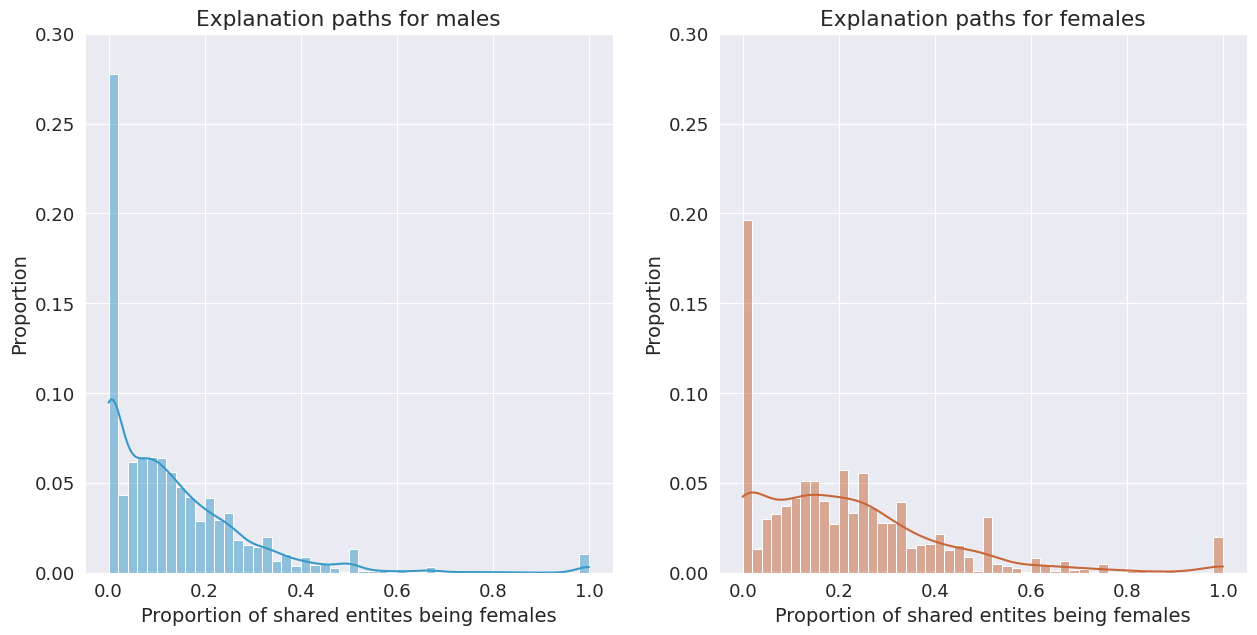

In [104]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

sns.histplot(data=male_shared_gender_df, ax=ax1, stat="proportion",
             x="female_proportion", kde=True,
             color="#3899C7",
             element="bars", legend=True, binwidth=.02)
ax1.set_title("Explanation paths for males")
ax1.set_xlabel("Proportion of shared entites being females")
ax1.set_ylim(0,0.30)

sns.histplot(data=female_shared_gender_df, ax=ax2, stat="proportion", multiple="stack",
             x="female_proportion", kde=True,
             color='#C76638',
             element="bars", legend=True, binwidth=.02)
ax2.set_title("Explanation paths for females")
ax2.set_xlabel("Proportion of shared entites being females")
ax2.set_ylim(0,0.30)


### Evaluate grouped by gender

In [105]:
male_shared_item_ids, male_shared_item_counts = np.unique(male_shared_entities_concatenated, return_counts=True)
female_shared_item_ids, female_shared_item_counts = np.unique(female_shared_entities_concatenated, return_counts=True)

In [106]:
male_shared_item_ids = np.flip(male_shared_item_ids[np.argsort(male_shared_item_counts)])
male_shared_item_counts = np.flip(male_shared_item_counts[np.argsort(male_shared_item_counts)])
female_shared_item_ids = np.flip(female_shared_item_ids[np.argsort(female_shared_item_counts)])
female_shared_item_counts = np.flip(female_shared_item_counts[np.argsort(female_shared_item_counts)])

In [107]:
male_shared_entity_count = np.sum(male_shared_item_counts)
female_shared_entity_count = np.sum(female_shared_item_counts)

In [108]:
for entity_idx, shared_entity in enumerate(male_shared_item_ids[:10]):
    print('Entity %s. \t %s \t %s%%' % (shared_entity, male_shared_item_counts[entity_idx], male_shared_item_counts[entity_idx]*100/male_shared_entity_count))

Entity 956. 	 1099 	 0.14745265146432962%
Entity 325. 	 888 	 0.1191428157418787%
Entity 5792. 	 816 	 0.10948258743848313%
Entity 2829. 	 666 	 0.08935711180640903%
Entity 1878. 	 631 	 0.0846611674922584%
Entity 829. 	 599 	 0.08036773269074926%
Entity 1735. 	 564 	 0.07567178837659863%
Entity 160. 	 557 	 0.07473259951376851%
Entity 735. 	 556 	 0.07459842967622135%
Entity 271. 	 487 	 0.06534071088546727%


In [109]:
for entity_idx, shared_entity in enumerate(female_shared_item_ids[:10]):
    print('Entity %s. \t %s \t %s%%' % (shared_entity, female_shared_item_counts[entity_idx], female_shared_item_counts[entity_idx]*100/female_shared_entity_count))

Entity 160. 	 197 	 0.14297430091372917%
Entity 5792. 	 168 	 0.12192732260663197%
Entity 735. 	 166 	 0.12047580686131493%
Entity 4702. 	 139 	 0.10088034429953478%
Entity 3182. 	 108 	 0.07838185024712055%
Entity 110. 	 102 	 0.07402730301116942%
Entity 3736. 	 101 	 0.07330154513851089%
Entity 4388. 	 97 	 0.07039851364787679%
Entity 2829. 	 97 	 0.07039851364787679%
Entity 219. 	 93 	 0.0674954821572427%


In [110]:
male_shared_users = male_shared_item_ids[male_shared_item_ids < dataset.user_num]
female_shared_users = female_shared_item_ids[female_shared_item_ids < dataset.user_num]

In [111]:
male_shared_user_gender = [internal_id_to_gender(idx) for idx in male_shared_users]
female_shared_user_gender = [internal_id_to_gender(idx) for idx in female_shared_users]

In [112]:
evaluate_gender_of_shared_entities(male_shared_user_gender)

({'f': 0.18317600669136097, 'm': 0.816823993308639}, 8369)

In [113]:
evaluate_gender_of_shared_entities(female_shared_user_gender)

({'f': 0.1927108530882116, 'm': 0.8072891469117884}, 6201)

In [114]:
evaluate_gender_of_shared_entities(male_shared_user_gender[:100])

({'f': 0.09, 'm': 0.91}, 100)

In [115]:
evaluate_gender_of_shared_entities(female_shared_user_gender[:100])

({'f': 0.28, 'm': 0.72}, 100)

### Evaluate with Fisher Exact Test

In [160]:
male_shared_entity_counts = {'f': 0, 'm': 0}
female_shared_entity_counts = {'f': 0, 'm': 0}
for (statistics, count) in male_shared_gender_statistics:
    female_counts = 0
    male_counts = 0
    if 'f' in statistics:
        male_shared_entity_counts['f'] += int(statistics['f'] * count)
    if 'm' in statistics:
        male_shared_entity_counts['m'] += int(statistics['m'] * count)

for (statistics, count) in female_shared_gender_statistics:
    female_counts = 0
    male_counts = 0
    if 'f' in statistics:
        female_shared_entity_counts['f'] += int(statistics['f'] * count)
    if 'm' in statistics:
        female_shared_entity_counts['m'] += int(statistics['m'] * count)



In [176]:
len(male_shared_gender_statistics)

7857

In [165]:
male_shared_entity_counts

{'f': 32008, 'm': 216522}

In [181]:
from scipy.stats import fisher_exact

_, fp_value = fisher_exact([[7857, 1824],[0.780622*1824, (1-0.780622)*1824]])
fp_value

0.0023697369802510087

In [179]:
fisher_exact([[7857, 1824],[0.866127*7857, (1-0.866127)*7857]])

(0.6652831219304691, 1.6626234154278403e-22)